# IF3170 Artificial Intelligence | Tugas Besar 2

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: xx

Group Members:
- Name (NIM)
- Name (NIM)
- ...

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from model.gaussian_nb import GaussianNaiveBayes
from model.id3 import ID3
from model.knn import KNN
# from missingpy import MissForest

import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [4]:
basic_features_train = pd.read_csv('../dataset/train/basic_features_train.csv')
content_features_train = pd.read_csv('../dataset/train/content_features_train.csv')
additional_features_train = pd.read_csv('../dataset/train/additional_features_train.csv')
labels_train = pd.read_csv('../dataset/train/labels_train.csv')
time_features_train = pd.read_csv('../dataset/train/time_features_train.csv')
flow_features_train = pd.read_csv('../dataset/train/flow_features_train.csv')

basic_features_test = pd.read_csv('../dataset/test/basic_features_test.csv')
content_features_test = pd.read_csv('../dataset/test/content_features_test.csv')
additional_features_test = pd.read_csv('../dataset/test/additional_features_test.csv')
time_features_test = pd.read_csv('../dataset/test/time_features_test.csv')
flow_features_test = pd.read_csv('../dataset/test/flow_features_test.csv')

metadata = pd.read_csv('../dataset/train/UNSW-NB15_features-modified.csv')

In [211]:
ids = np.array([
    basic_features_train['id'],
    additional_features_train['id'],
    additional_features_train['id'],
    labels_train['id'],
    time_features_train['id'],
    flow_features_train['id']
])

matching_rows = (ids[0] == ids).all(axis=0)
print("Number of matching rows:", matching_rows.sum())
print("Rows of table: ", len(basic_features_train))

Number of matching rows: 175341
Rows of table:  175341


In [212]:
ids = np.array([
    basic_features_test['id'],
    additional_features_test['id'],
    additional_features_test['id'],
    time_features_test['id'],
    flow_features_test['id']
])

matching_rows = (ids[0] == ids).all(axis=0)
print("Number of matching rows:", matching_rows.sum())
print("Rows of table: ", len(basic_features_test))

Number of matching rows: 20583
Rows of table:  20583


In [213]:
df_train = pd.merge(basic_features_train, content_features_train, on='id')
df_train = pd.merge(df_train, additional_features_train, on='id')
df_train = pd.merge(df_train, labels_train, on='id')
df_train = pd.merge(df_train, time_features_train, on='id')
df_train = pd.merge(df_train, flow_features_train, on='id')

df_test = pd.merge(basic_features_test, content_features_test, on='id')
df_test = pd.merge(df_test, additional_features_test, on='id')
df_test = pd.merge(df_test, time_features_test, on='id')
df_test = pd.merge(df_test, flow_features_test, on='id')
df_train.drop('label',axis=1, inplace=True)
# df_test.drop('label',axis=1, inplace=True)

In [214]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [215]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 57.52 MB
Memory usage after optimization is: 31.44 MB
Decreased by 45.3%


# Exploratory Data Analysis (Optional)

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis.

In [216]:
# Write your code here

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

In [217]:
target_columns = ['attack_cat']

In [218]:
X_train = df_train.drop(target_columns, axis=1)
y_train = df_train[target_columns]

In [219]:
X_train.drop('id', axis=1, inplace=True)

In [220]:
cat_columns = metadata['Name'].loc[(metadata['Type '] == 'nominal') | (metadata['Type '] == 'binary') | (metadata['Type '] == 'Binary')].values
indices_to_remove = [i for i, val in enumerate(cat_columns) if val in target_columns or val == 'label']
cat_columns = np.delete(cat_columns, indices_to_remove)
num_columns = [x for x in X_train.columns if x not in cat_columns]

In [221]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

In [222]:
len(X_train[X_train.isna().any(axis=1)]) * 100 /len(X_train)

87.81225048477245

In [223]:
for column in num_columns:
    missing_percentage = X_train[column].isna().sum() / len(X_train) * 100
    print(f"Column {column} - {missing_percentage:.2f}% missing values")

Column dur - 4.96% missing values
Column sbytes - 4.87% missing values
Column dbytes - 5.04% missing values
Column sttl - 5.01% missing values
Column dttl - 4.95% missing values
Column sloss - 4.99% missing values
Column dloss - 5.14% missing values
Column sload - 4.99% missing values
Column dload - 5.06% missing values
Column spkts - 4.96% missing values
Column dpkts - 4.93% missing values
Column swin - 4.97% missing values
Column dwin - 4.99% missing values
Column stcpb - 4.95% missing values
Column dtcpb - 5.04% missing values
Column smean - 5.00% missing values
Column dmean - 5.05% missing values
Column trans_depth - 4.99% missing values
Column response_body_len - 4.99% missing values
Column ct_state_ttl - 4.99% missing values
Column ct_flw_http_mthd - 4.95% missing values
Column ct_ftp_cmd - 5.03% missing values
Column ct_srv_src - 5.06% missing values
Column ct_srv_dst - 5.00% missing values
Column ct_dst_ltm - 4.99% missing values
Column ct_src_ltm - 5.01% missing values
Column 

In [224]:
for column in cat_columns:
    missing_percentage = X_train[column].isna().sum() / len(X_train) * 100
    print(f"Column {column} - {missing_percentage:.2f}% missing values")

Column proto - 5.01% missing values
Column state - 5.01% missing values
Column service - 5.02% missing values
Column is_sm_ips_ports - 5.01% missing values
Column is_ftp_login - 4.93% missing values


In [225]:
print("Skewness of each column:")
for column in num_columns:
    print(column, ":", df_train[column].skew())

Skewness of each column:
dur : 7.497794
sbytes : 45.493176
dbytes : 39.855274
sttl : -0.6777894
dttl : 0.8955747
sloss : 45.581436
dloss : 39.579338
sload : 8.684336
dload : 4.688723
spkts : 40.68575
dpkts : 37.33312
swin : 0.17819831
dwin : 0.19773118
stcpb : 1.0809963
dtcpb : 1.0806566
smean : 3.7218378
dmean : 2.8268428
trans_depth : 164.97836
response_body_len : 76.23126
ct_state_ttl : 0.92988384
ct_flw_http_mthd : 23.269417
ct_ftp_cmd : 9.80617
ct_srv_src : 1.5207442
ct_srv_dst : 1.5277202
ct_dst_ltm : 2.050049
ct_src_ltm : 1.8409625
ct_src_dport_ltm : 2.1681974
ct_dst_sport_ltm : 1.6956129
ct_dst_src_ltm : 1.5529943
sjit : 17.59772
djit : 29.669842
sinpkt : 7.9120097
dinpkt : 30.085854
tcprtt : 4.115667
synack : 5.877091
ackdat : 5.705092


In [226]:
class CatMissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, type = 1, n_neighbors = 50):
        self.type = type
        self.n_neighbors = n_neighbors
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if (self.type == 1):
            simple_imputer = SimpleImputer(strategy='most_frequent')
            X = pd.DataFrame(simple_imputer.fit_transform(X), columns=X.columns)
        elif (self.type == 2):
            for col in X.columns:
                X[col] = X[col].fillna("Missing")
        elif (self.type == 3):
            knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)
            X = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

        return X

In [227]:
class NumMissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, type = 1, n_neighbors = 50):
        self.type = type
        self.n_neighbors = n_neighbors
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if (self.type == 1):
            skewness = X.skew()

            mean_imputer = SimpleImputer(strategy='mean')
            median_imputer = SimpleImputer(strategy='median')

            for column in X.columns:
                if skewness[column] < 1:
                    X[column] = mean_imputer.fit_transform(X[[column]])
                else:
                    X[column] = median_imputer.fit_transform(X[[column]])
        elif (self.type == 2):
            knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)
            X = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

        return X

In [228]:
missingVal_pipeline = ColumnTransformer([
 ("num", NumMissingValueHandler(), num_columns),
 ("cat", CatMissingValueHandler(), cat_columns)
])

# m for missing
m_X_train = missingVal_pipeline.fit_transform(X_train)
m_X_train_df = pd.DataFrame(m_X_train, columns=list(num_columns) + list(cat_columns))
m_X_train_df

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,...,sinpkt,dinpkt,tcprtt,synack,ackdat,proto,state,service,is_sm_ips_ports,is_ftp_login
0,0.778778,608.0,646.0,254.0,252.0,2.0,3.0,5629.332031,5978.597168,10.0,...,86.430664,81.175217,0.12221,0.0482,0.07401,tcp,FIN,-,0.0,0.0
1,0.000009,200.0,0.0,254.0,79.512207,0.0,0.0,88888888.0,0.0,2.0,...,0.009,0.0,0.0,0.0,0.0,mhrp,INT,-,0.0,0.0
2,0.000009,114.0,0.0,254.0,0.0,0.0,0.0,50666664.0,0.0,2.0,...,0.009,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
3,0.000008,114.0,0.0,254.0,0.0,0.0,0.0,57000000.0,0.0,2.0,...,0.280048,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
4,0.627731,818.0,1062.0,62.0,252.0,2.0,2.0,9392.557617,1411.759277,10.0,...,69.747887,74.994713,0.203372,0.102021,0.101351,tcp,FIN,http,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140267,1.24096,10988.0,354.0,254.0,252.0,5.0,1.0,66413.101562,1998.452759,16.0,...,82.730667,159.926422,0.1431,0.101635,0.041465,tcp,FIN,-,0.0,0.0
140268,0.949207,564.0,354.0,254.0,252.0,2.0,1.0,4281.46875,2612.707275,10.0,...,102.387558,126.50071,0.135252,0.063701,0.071551,tcp,FIN,-,0.0,0.0
140269,0.000002,114.0,162.0,254.0,0.0,0.0,0.0,228000000.0,0.0,2.0,...,0.002,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
140270,0.000003,450.0,0.0,179.562592,0.0,0.0,0.0,152000000.0,0.0,2.0,...,0.003,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0


### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

In [229]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="clapping"): 
        self.method = method
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)

        if (self.method == "iqr"):
            for col in X_df.columns:
                Q1 = X_df[col].quantile(0.25)  
                Q3 = X_df[col].quantile(0.75)  
                IQR = Q3 - Q1                  

                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                X_df[col] = X_df[col].clip(lower=lower_bound, upper=upper_bound)
        else:
            for col in X_df.columns:
                if X_df[col].max()>10*X_df[col].median() and X_df[col].max()>10 :
                    X_df[col] = np.where(X_df[col]<X_df[col].quantile(0.95), X_df[col], X_df[col].quantile(0.95))

        return X_df.values

num_pipeline = Pipeline([
 ('imputer', NumMissingValueHandler()),
 ('outlier_handler', OutlierHandler()),
 ])

num_cat_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_columns),
 ("cat", CatMissingValueHandler(), cat_columns)
])

# o for outlier
mo_X_train = num_cat_pipeline.fit_transform(X_train)
mo_X_train_df = pd.DataFrame(mo_X_train, columns=list(num_columns) + list(cat_columns))
mo_X_train_df

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,...,sinpkt,dinpkt,tcprtt,synack,ackdat,proto,state,service,is_sm_ips_ports,is_ftp_login
0,0.778778,608.0,646.0,254.0,252.0,2.0,3.0,5629.332031,5978.597168,10.0,...,86.430664,81.175217,0.12221,0.0482,0.07401,tcp,FIN,-,0.0,0.0
1,0.000009,200.0,0.0,254.0,79.512207,0.0,0.0,88888888.0,0.0,2.0,...,0.009,0.0,0.0,0.0,0.0,mhrp,INT,-,0.0,0.0
2,0.000009,114.0,0.0,254.0,0.0,0.0,0.0,50666664.0,0.0,2.0,...,0.009,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
3,0.000008,114.0,0.0,254.0,0.0,0.0,0.0,57000000.0,0.0,2.0,...,0.280048,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
4,0.627731,818.0,1062.0,62.0,252.0,2.0,2.0,9392.557617,1411.759277,10.0,...,69.747887,74.994713,0.203372,0.102021,0.101351,tcp,FIN,http,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140267,1.24096,10988.0,354.0,254.0,252.0,5.0,1.0,66413.101562,1998.452759,16.0,...,82.730667,155.786316,0.1431,0.101635,0.041465,tcp,FIN,-,0.0,0.0
140268,0.949207,564.0,354.0,254.0,252.0,2.0,1.0,4281.46875,2612.707275,10.0,...,102.387558,126.50071,0.135252,0.063701,0.071551,tcp,FIN,-,0.0,0.0
140269,0.000002,114.0,162.0,254.0,0.0,0.0,0.0,228000000.0,0.0,2.0,...,0.002,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
140270,0.000003,450.0,0.0,179.562592,0.0,0.0,0.0,152000000.0,0.0,2.0,...,0.003,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0


### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [230]:
duplicate_rows_train = df_train[df_train.duplicated()]
duplicate_rows_test = df_test[df_test.duplicated()]
print(duplicate_rows_train)
print(duplicate_rows_test)

Empty DataFrame
Columns: [state, dur, sbytes, dbytes, sttl, dttl, sloss, dloss, service, sload, dload, spkts, dpkts, id, swin, dwin, stcpb, dtcpb, smean, dmean, trans_depth, response_body_len, is_sm_ips_ports, ct_state_ttl, ct_flw_http_mthd, is_ftp_login, ct_ftp_cmd, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, attack_cat, sjit, djit, sinpkt, dinpkt, tcprtt, synack, ackdat, proto]
Index: []

[0 rows x 43 columns]
Empty DataFrame
Columns: [state, dur, sbytes, dbytes, sttl, dttl, sloss, dloss, service, sload, dload, spkts, dpkts, id, swin, dwin, stcpb, dtcpb, smean, dmean, trans_depth, response_body_len, is_sm_ips_ports, ct_state_ttl, ct_flw_http_mthd, is_ftp_login, ct_ftp_cmd, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, sjit, djit, sinpkt, dinpkt, tcprtt, synack, ackdat, proto]
Index: []

[0 rows x 42 columns]


There are no duplicate rows both in train data and test data.

### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

#### A. Remove Useless Attribute

In [231]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        return X.drop('id', axis=1)

#### B. Remove Similiar Attribute

In [232]:
constant_columns = mo_X_train_df[num_columns].loc[:, mo_X_train_df[num_columns].std() == 0]
print("Constant columns:", constant_columns.columns.tolist())

Constant columns: []


Constant column will be removed for correlation matrix

In [233]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(mo_X_train_df[num_columns])
scaled_df = pd.DataFrame(scaled_data, columns=num_columns)

In [234]:
corr_df = scaled_df[num_columns].loc[:, mo_X_train_df[num_columns].std() != 0]
correlation_matrix = corr_df.corr()

high_corr = correlation_matrix.unstack() 
high_corr = high_corr[high_corr > 0.9]
high_corr = high_corr[high_corr < 1.0]
high_corr = high_corr.sort_values(ascending=False)

# Print the result
print("High correlation pairs:")
print(high_corr)

High correlation pairs:
trans_depth       ct_flw_http_mthd    0.947453
ct_flw_http_mthd  trans_depth         0.947453
swin              dwin                0.940504
dwin              swin                0.940504
ct_srv_src        ct_srv_dst          0.920662
ct_srv_dst        ct_srv_src          0.920662
                  ct_dst_src_ltm      0.909276
ct_dst_src_ltm    ct_srv_dst          0.909276
dloss             dpkts               0.906321
dpkts             dloss               0.906321
ct_srv_src        ct_dst_src_ltm      0.905083
ct_dst_src_ltm    ct_srv_src          0.905083
dtype: float64


In [235]:
removed_attributes = set([x[0] for x in high_corr.index][0::2])
print("Removed attribute: ", removed_attributes)
fmo_X_train_df = mo_X_train_df.drop(removed_attributes, axis=1)
fmo_X_train_df

Removed attribute:  {'trans_depth', 'ct_srv_src', 'ct_srv_dst', 'dloss', 'swin'}


,dur,sbytes,dbytes,sttl,dttl,sloss,sload,dload,spkts,dpkts,...,sinpkt,dinpkt,tcprtt,synack,ackdat,proto,state,service,is_sm_ips_ports,is_ftp_login
0,0.778778,608.0,646.0,254.0,252.0,2.0,5629.332031,5978.597168,10.0,10.0,...,86.430664,81.175217,0.12221,0.0482,0.07401,tcp,FIN,-,0.0,0.0
1,0.000009,200.0,0.0,254.0,79.512207,0.0,88888888.0,0.0,2.0,0.0,...,0.009,0.0,0.0,0.0,0.0,mhrp,INT,-,0.0,0.0
2,0.000009,114.0,0.0,254.0,0.0,0.0,50666664.0,0.0,2.0,0.0,...,0.009,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
3,0.000008,114.0,0.0,254.0,0.0,0.0,57000000.0,0.0,2.0,0.0,...,0.280048,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
4,0.627731,818.0,1062.0,62.0,252.0,2.0,9392.557617,1411.759277,10.0,8.0,...,69.747887,74.994713,0.203372,0.102021,0.101351,tcp,FIN,http,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140267,1.24096,10988.0,354.0,254.0,252.0,5.0,66413.101562,1998.452759,16.0,8.0,...,82.730667,155.786316,0.1431,0.101635,0.041465,tcp,FIN,-,0.0,0.0
140268,0.949207,564.0,354.0,254.0,252.0,2.0,4281.46875,2612.707275,10.0,8.0,...,102.387558,126.50071,0.135252,0.063701,0.071551,tcp,FIN,-,0.0,0.0
140269,0.000002,114.0,162.0,254.0,0.0,0.0,228000000.0,0.0,2.0,0.0,...,0.002,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0
140270,0.000003,450.0,0.0,179.562592,0.0,0.0,152000000.0,0.0,2.0,0.0,...,0.003,0.0,0.0,0.0,0.0,udp,INT,dns,0.0,0.0


In [236]:
num_columns = [x for x in num_columns if x not in removed_attributes]
cat_columns = [x for x in cat_columns if x not in removed_attributes]

In [237]:
class SimiliarAttributeRemover(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)
        
        scaled_data = scaler.fit_transform(X_df)
        scaled_df = pd.DataFrame(scaled_data)

        # remove constant attribute
        corr_df = scaled_df.loc[:, scaled_df.std() != 0]
        correlation_matrix = corr_df.corr()

        high_corr = correlation_matrix.unstack() 
        high_corr = high_corr[high_corr > 0.9]
        high_corr = high_corr[high_corr < 1.0]
        high_corr = high_corr.sort_values(ascending=False)


        removed_attributes = [x[0] for x in high_corr.index][0::2]
        
        X_df.drop(removed_attributes, axis=1)

        return X_df.values

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

In [238]:
# Write your code here

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

In [239]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.target_means_ = {}

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        for col in X.columns:
            self.target_means_[col] = y.groupby(X[col]).mean().to_dict()
        
        return self
    
    def transform(self, X, y=None):

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_encoded = X.copy()
        for col, mapping in self.target_means_.items():
            if col in X_encoded.columns:
                X_encoded[col] = X_encoded[col].map(mapping).fillna(0)

        return X_encoded

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

In [240]:
y_train.value_counts()/len(y_train)

attack_cat    
Normal            0.318995
Generic           0.228306
Exploits          0.190751
Fuzzers           0.103706
DoS               0.069900
Reconnaissance    0.060033
Analysis          0.011520
Backdoor          0.009831
Shellcode         0.006231
Worms             0.000727
Name: count, dtype: float64

### IV. Data Normalization

Data normalization is used to achieve a standard distribution. Without normalization, models or processes that rely on the assumption of normality may not work correctly. Normalization helps reduce the magnitude effect and ensures numerical stability during optimization.

In [241]:
# Write your code here

### V. Dimensionality Reduction

Dimensionality reduction is a technique used in data preprocessing to reduce the number of input features (dimensions) in a dataset while retaining as much important information as possible. It is essential when dealing with high-dimensional data, where too many features can cause problems like increased computational costs, overfitting, and difficulty in visualization. Reducing dimensions simplifies the data, making it easier to analyze and improving the performance of machine learning models.

One of the main approaches to dimensionality reduction is feature extraction. Feature extraction creates new, smaller sets of features that capture the essence of the original data. Common techniques include:

1. **Principal Component Analysis (PCA)**: Converts correlated features into a smaller number of uncorrelated "principal components."
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: A visualization-focused method to project high-dimensional data into 2D or 3D spaces.
3. **Autoencoders**: Neural networks that learn compressed representations of the data.

In [242]:
### Label encoding ###
LABELS = fmo_X_train_df.columns

encoder = LabelEncoder()

for col in cat_columns:
    # Check if object
    fmo_X_train_df[col] = encoder.fit_transform(fmo_X_train_df[col]) 

In [243]:
from sklearn.preprocessing import MinMaxScaler

### Scaling ###
mm_scaler = MinMaxScaler() 

# Apply Min-Max Scaling
fmo_X_train_df[LABELS] = mm_scaler.fit_transform(fmo_X_train_df[LABELS])

In [244]:
len(LABELS)

36

Variance from sklearn model:  [39.87 53.   63.72 69.65 74.02 77.89 81.35 83.41 85.28 87.09 88.43 89.74
 90.84 91.87 92.8  93.67 94.39 95.08 95.68 96.23 96.73 97.22 97.67 98.07
 98.44 98.78 99.09 99.37 99.57 99.76 99.87 99.94 99.96 99.97 99.97 99.97]


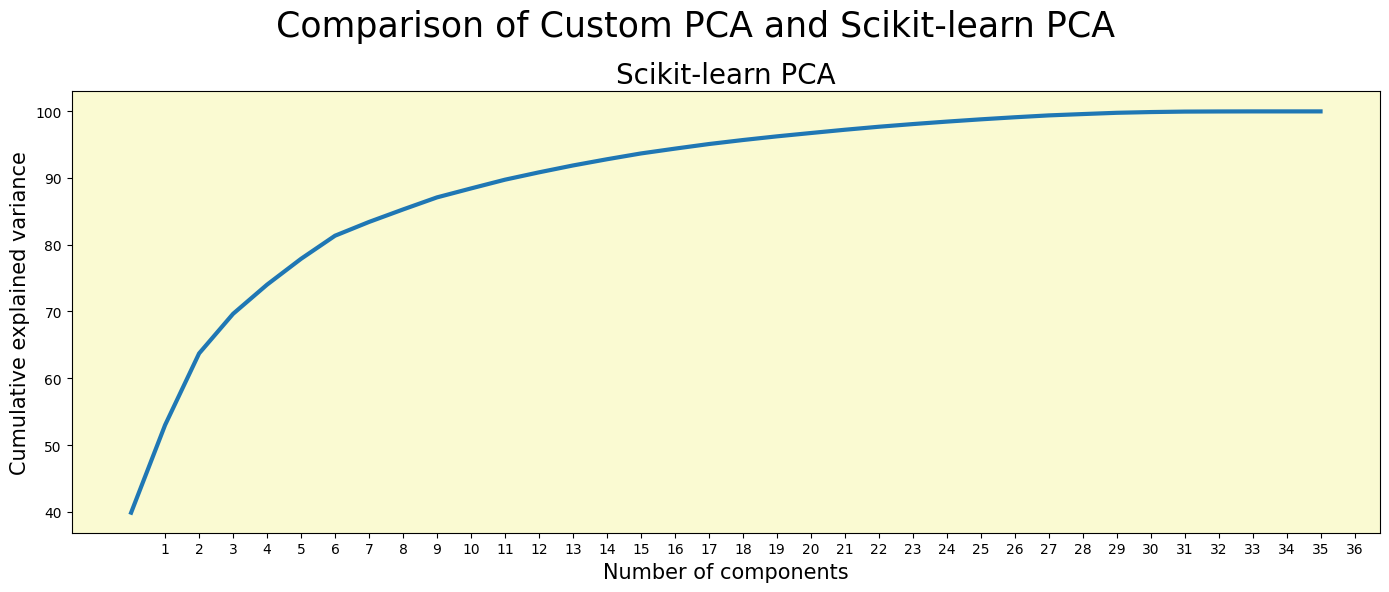

In [245]:
from sklearn.decomposition import PCA

# Fit sklearn PCA
pca = PCA(n_components=36)
pca.fit(fmo_X_train_df)

# The amount of variance that each PC explains
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)
print("Variance from sklearn model: ", var)

# Plotting
fig, ax= plt.subplots(figsize=(14, 6))

# Plot for scikit-learn PCA
ax.plot(var, linewidth=3)
ax.set_xlabel('Number of components', fontsize=15)
ax.set_ylabel('Cumulative explained variance', fontsize=15)
ax.set_title('Scikit-learn PCA', fontsize=20)
ax.set_xticks(np.arange(1, len(var) + 1, step=1))
ax.set_facecolor('lightgoldenrodyellow')

# Overall figure settings
fig.suptitle('Comparison of Custom PCA and Scikit-learn PCA', fontsize=25)
plt.tight_layout()
plt.show()

In [246]:
pca = PCA(n_components=18)
rfmo_X_train_df = pd.DataFrame(pca.fit_transform(fmo_X_train_df), columns=[x for x in range(1, 19)])
rfmo_X_train_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.747079,0.728702,-0.080090,-0.202557,-0.154168,-0.334232,0.100397,-0.263503,0.152209,0.378197,0.104568,-0.024827,0.114756,0.077445,-0.034942,0.092725,-0.070014,-0.036028
1,-0.500921,0.141941,-0.751112,-0.060047,-0.069230,0.027721,0.147475,-0.147917,-0.061002,0.010248,0.010337,0.198691,0.031334,0.038268,0.012567,-0.092043,0.079792,-0.057927
2,-1.400678,0.039713,0.833552,0.020633,0.024642,-0.049682,-0.078418,-0.089469,-0.051573,0.006438,-0.081480,0.022972,0.019719,0.019523,-0.140774,-0.056066,-0.013750,-0.016169
3,-0.931389,0.021051,-0.029048,0.014197,-0.015944,-0.001561,0.017619,-0.078526,-0.028705,0.005920,-0.170244,-0.036825,0.026210,-0.019262,0.058175,-0.070460,-0.021815,0.065095
4,0.764270,0.467211,0.304673,0.973677,-0.075196,0.632629,-0.251525,-0.598425,0.071788,-0.002683,0.440925,-0.181139,0.141313,-0.105561,-0.016535,0.194240,-0.144474,-0.290429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140267,1.196501,0.835712,0.063313,-0.843319,0.257166,0.304442,-0.146314,-0.011812,0.207880,-0.106332,0.140449,-0.260532,-0.333567,0.435424,-0.152588,-0.240005,0.021236,-0.101327
140268,1.147160,0.957245,0.150972,-0.239761,-0.289754,-0.472116,0.116560,0.266326,-0.119411,-0.007623,-0.080520,-0.045141,-0.135921,-0.064506,-0.045684,-0.075785,0.025287,-0.074986
140269,-1.263102,0.055713,0.284599,-0.050491,-0.015266,0.150519,0.245798,0.178913,0.111523,-0.015878,0.210614,0.081482,0.041163,-0.298991,-0.027079,-0.257980,-0.101805,0.003969
140270,-1.039008,-0.087095,0.124509,0.085792,0.026207,0.061473,-0.032036,0.114785,0.110190,-0.016729,0.089619,0.046780,0.014861,-0.223637,-0.027366,-0.159995,-0.131335,-0.017029


# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [247]:
class CatMissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, type = 1, n_neighbors = 50):
        self.type = type
        self.n_neighbors = n_neighbors
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if (self.type == 1):
            simple_imputer = SimpleImputer(strategy='most_frequent')
            X = pd.DataFrame(simple_imputer.fit_transform(X), columns=X.columns)
        elif (self.type == 2):
            for col in X.columns:
                X[col] = X[col].fillna("Missing")
        elif (self.type == 3):
            knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)
            X = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

        return X

In [248]:
class NumMissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, type = 1, n_neighbors = 50):
        self.type = type
        self.n_neighbors = n_neighbors
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if (self.type == 1):
            skewness = X.skew()

            mean_imputer = SimpleImputer(strategy='mean')
            median_imputer = SimpleImputer(strategy='median')

            for column in X.columns:
                if skewness[column] < 1:
                    X[column] = mean_imputer.fit_transform(X[[column]])
                else:
                    X[column] = median_imputer.fit_transform(X[[column]])
        elif (self.type == 2):
            knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)
            X = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

        return X

In [249]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="clapping"): 
        self.method = method
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)

        if (self.method == "iqr"):
            for col in X_df.columns:
                Q1 = X_df[col].quantile(0.25)  
                Q3 = X_df[col].quantile(0.75)  
                IQR = Q3 - Q1                  

                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                X_df[col] = X_df[col].clip(lower=lower_bound, upper=upper_bound)
        else:
            for col in X_df.columns:
                if X_df[col].max()>10*X_df[col].median() and X_df[col].max()>10 :
                    X_df[col] = np.where(X_df[col]<X_df[col].quantile(0.95), X_df[col], X_df[col].quantile(0.95))

        return X_df.values

In [250]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        return X.drop('id', axis=1)

In [251]:
class SimiliarAttributeRemover(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)
        
        scaled_data = scaler.fit_transform(X_df)
        scaled_df = pd.DataFrame(scaled_data, columns=X_df.columns)

        # remove constant attribute
        corr_df = scaled_df.loc[:, scaled_df.std() != 0]
        correlation_matrix = corr_df.corr()

        high_corr = correlation_matrix.unstack() 
        high_corr = high_corr[high_corr > 0.9]
        high_corr = high_corr[high_corr < 1.0]
        high_corr = high_corr.sort_values(ascending=False)


        removed_attributes = [x[0] for x in high_corr.index][0::2]
        
        X_df.drop(removed_attributes, axis=1)

        return X_df.values

In [252]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import pandas as pd

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.target_means_ = {}
        self.global_mean_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if y is None:
            raise ValueError("Target variable `y` must not be None.")

        label_encoder_ = LabelEncoder()
        y_encoded = pd.Series(label_encoder_.fit_transform(y))

        self.global_mean_ = y_encoded.mean()
        for col in X.columns:
            self.target_means_[col] = y_encoded.groupby(X[col]).mean().to_dict()
        
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_encoded = X.copy()
        for col, mapping in self.target_means_.items():
            if col in X_encoded.columns:
                # Map the encoded values, fill NaNs with the global mean
                X_encoded[col] = X_encoded[col].map(mapping).fillna(self.global_mean_)

        return X_encoded


In [253]:
# Note: You can add or delete preprocessing components from this pipeline
cat_pipeline = Pipeline([
    ('imputer', CatMissingValueHandler()),
    ('encoder', TargetEncoder()),
    # ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

num_pipeline = Pipeline([
    ('att_remover', SimiliarAttributeRemover()),
    ('imputer', NumMissingValueHandler()),
    ('numClipper', OutlierHandler()),
    # ('transformer', PowerTransformer(method='yeo-johnson')),
    ('Scaler', StandardScaler())
])

num_cat_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns)
])

final_pipeline = Pipeline([
    # ('column_dropper', ColumnDropper()),
    ('num_cat', num_cat_pipeline),
    ('d_reduction', PCA(n_components=18)),
    ('model', KNN())
])

In [254]:
# X_train_prepared = final_pipeline.fit_transform(X_train, y_train)

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `attack_cat`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [258]:
param_grid = [
    # K Nearst Neighbot
    {
        'num_cat__num__imputer__type': [1,2],
        'num_cat__cat__imputer__type': [1,2,3],
        'num_cat__num__numClipper__method': ['clapping', 'iqr'],
        'model': [KNN()],
        'model__distance': ['euclidean', 'manhattan'],
        'model__n_neighbors': [50, 100, 150]
    },
    # Gaussian Naive Bayes
    {
        'num_cat__num__imputer__type': [1,2],
        'num_cat__cat__imputer__type': [1,2,3],
        'num_cat__num__numClipper__method': ['clapping', 'iqr'],
        'model': [GaussianNaiveBayes()],
    },
    # ID3
    {
        'num_cat__num__imputer__type': [1,2],
        'num_cat__cat__imputer__type': [1,2,3],
        'num_cat__num__numClipper__method': ['clapping', 'iqr'],
        'model': [ID3()],
        'model__max_depth': [3, 5, 7]
    },
]

In [ ]:
grid_search = GridSearchCV(
    estimator=final_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro'
)

In [260]:
grid_search.fit(X_train, y_train)

# Get the best parameters, model, and pipeline configuration
print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)
print("Best Cross-Validation Score:", grid_search.best_score_)

PicklingError: Could not pickle the task to send it to the workers.

## A. KNN

In [ ]:
# Type your code here
knn = KNN()

## B. Naive Bayes

In [ ]:
# Type your code here

## C. ID3

In [ ]:
# Type your code here

## D. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

In [ ]:
# Type your code here

## E. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `attack_cat` column.

In [ ]:
# Type your code here

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

`Provide your analysis here`